In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency

In [2]:
inflows = pd.read_parquet('C:/Users/bdion/Downloads/DSC180A/dsc180a/DSC180A/data/ucsd-inflows.pqt')
outflows = pd.read_parquet('C:/Users/bdion/Downloads/DSC180A/dsc180a/DSC180A/data/ucsd-outflows.pqt')

inflows.posted_date  = pd.to_datetime(inflows.posted_date, format='%Y-%m-%d')
outflows.posted_date = pd.to_datetime(outflows.posted_date, format='%Y-%m-%d')

In [3]:
inflows.shape[0], outflows.shape[0], inflows.shape[0] + outflows.shape[0]

(513115, 2597488, 3110603)

## Splitting data:

- Datasets together:

In [4]:
df = pd.concat([inflows, outflows])

# Splitting based on prism_consumer_id:
cids = df.prism_consumer_id.unique()
train_cids, test_cids = train_test_split(cids, test_size=0.3, random_state=420) # 70 / 30 split

# Features and labels for train and test sets:
X_train = df[df.prism_consumer_id.isin(train_cids)]
y_train = X_train.category
X_test  = df[df.prism_consumer_id.isin(test_cids)]
y_test  = X_test.category

len(X_train), len(X_test)

(2178239, 932364)

- X_train, y_train: training set (70% of the data)
- X_test, y_test: test set (30% of the data)

## Checking bias between training and test set:

In [5]:
cat_train_count = y_train.value_counts().reset_index()

alt.Chart(cat_train_count).mark_bar().encode(
    alt.X('category', axis=alt.Axis(labelAngle=90, title="Category")),
    alt.Y('count', title='Count', stack=None),
).properties(
    width=350, 
    height=500,
    title="Category Proportions for Training Labels"
)

alt.Chart(...)

In [6]:
cat_test_count = y_test.value_counts().reset_index()

alt.Chart(cat_test_count).mark_bar().encode(
    alt.X('category', axis=alt.Axis(labelAngle=90, title="Category")),
    alt.Y('count', title='Count', stack=None),
).properties(
    width=350, 
    height=500,
    title="Category Proportions for Testing Labels"
)

alt.Chart(...)

In [7]:
X_train[['amount']].describe()

,amount
count,2.178239e+06
mean,2.483080e+02
std,2.805930e+03
min,0.000000e+00
25%,1.000000e+01
50%,2.799000e+01
75%,9.778000e+01
max,1.154966e+06


In [8]:
X_train.memo.value_counts(normalize=True) * 100

memo
EXTERNAL_TRANSFER                                  15.398861
AUTOMOTIVE                                          6.815414
SELF_TRANSFER                                       5.893614
UNCATEGORIZED                                       3.934738
ATM_CASH                                            3.820380
                                                     ...    
Cash App*Jamari Cheeley                             0.000046
Cash App*Tapk68                                     0.000046
Cash App*Tapk78                                     0.000046
Kwik Jo                                             0.000046
DEBIT CARD DD DOORDASH CARLSJR. XXX-XXX-XXXX CA     0.000046
Name: proportion, Length: 371489, dtype: float64

In [9]:
X_test[['amount']].describe()

,amount
count,932364.000000
mean,228.532419
std,2288.162826
min,0.000000
25%,10.000000
50%,27.000000
75%,93.190000
max,654853.210000


In [10]:
X_test.memo.value_counts(normalize=True) * 100

memo
EXTERNAL_TRANSFER                                                                           15.241579
AUTOMOTIVE                                                                                   6.448447
SELF_TRANSFER                                                                                5.935557
ATM_CASH                                                                                     3.693193
UNCATEGORIZED                                                                                3.400067
                                                                                              ...    
PURCHASE AUTHORIZED ON 09/16 J Mart 405 ATHENS AL PXXXXXXXXXXXXXXX CARD XXXX                 0.000107
PURCHASE AUTHORIZED ON 09/16 CASH APP*RAUL MEND XXXXXXXXXX CA SXXXXXXXXXXXXXXX CARD XXXX     0.000107
PURCHASE AUTHORIZED ON 11/11 CASH APP*TYLER*ADD XXXXXXXXXX CA SXXXXXXXXXXXXXXX CARD XXXX     0.000107
PURCHASE AUTHORIZED ON 08/31 Mini Mart ATHENS AL PXXXXXXXXXXXXXXX CARD XXXX  

## Statistics to detect bias between traiing and test set:
- Closer look at the transaction amount tied to each Prism consumer id:

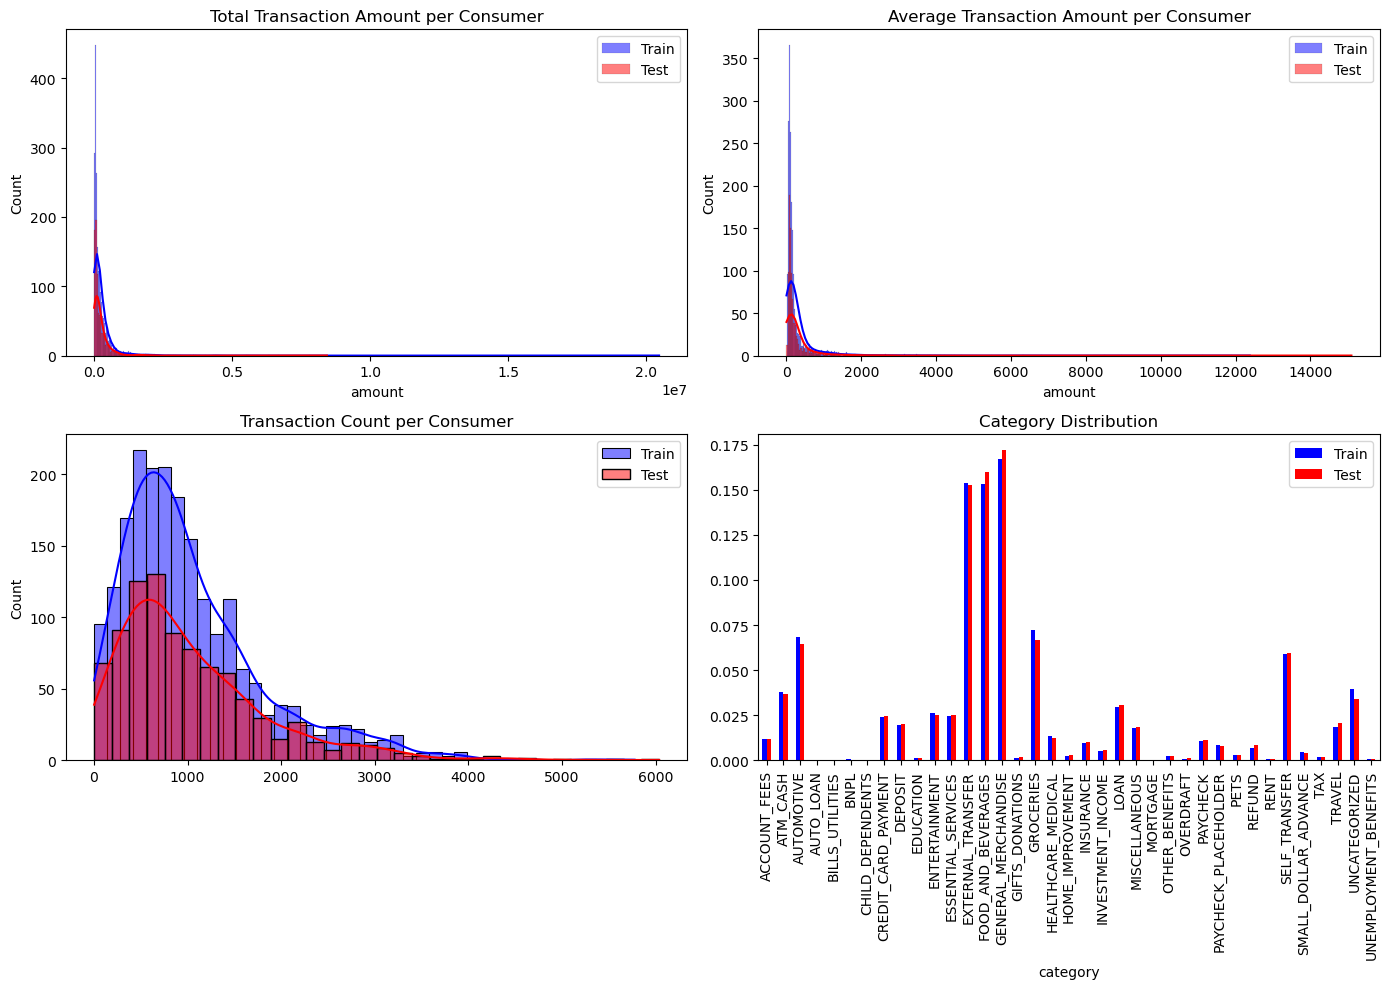

In [11]:
def plot_distribution(X_train, X_test):
    # Total transaction amount per consumer
    train_amount_per_consumer = X_train.groupby('prism_consumer_id')['amount'].sum()
    test_amount_per_consumer = X_test.groupby('prism_consumer_id')['amount'].sum()

    # Average transaction amount per consumer
    train_avg_amount_per_consumer = X_train.groupby('prism_consumer_id')['amount'].mean()
    test_avg_amount_per_consumer = X_test.groupby('prism_consumer_id')['amount'].mean()

    # Transaction count per consumer
    train_txn_count_per_consumer = X_train.groupby('prism_consumer_id').size()
    test_txn_count_per_consumer = X_test.groupby('prism_consumer_id').size()

    # Category distribution
    category_train_dist = X_train['category'].value_counts(normalize=True)
    category_test_dist = X_test['category'].value_counts(normalize=True)

    plt.figure(figsize=(14, 10))

    # Total transaction amounts per consumer
    plt.subplot(2, 2, 1)
    sns.histplot(train_amount_per_consumer, kde=True, color='blue', label='Train')
    sns.histplot(test_amount_per_consumer, kde=True, color='red', label='Test')
    plt.title('Total Transaction Amount per Consumer')
    plt.legend()

    # Average transaction amount per consumer
    plt.subplot(2, 2, 2)
    sns.histplot(train_avg_amount_per_consumer, kde=True, color='blue', label='Train')
    sns.histplot(test_avg_amount_per_consumer, kde=True, color='red', label='Test')
    plt.title('Average Transaction Amount per Consumer')
    plt.legend()

    # Transaction count per consumer
    plt.subplot(2, 2, 3)
    sns.histplot(train_txn_count_per_consumer, kde=True, color='blue', label='Train')
    sns.histplot(test_txn_count_per_consumer, kde=True, color='red', label='Test')
    plt.title('Transaction Count per Consumer')
    plt.legend()

    # Category distribution (bar plot)
    plt.subplot(2, 2, 4)
    category_comparison = pd.DataFrame({
        'train': category_train_dist,
        'test': category_test_dist
    }).fillna(0)
    category_comparison.plot(kind='bar', ax=plt.gca(), color=['blue', 'red'])
    plt.title('Category Distribution')
    plt.legend(['Train', 'Test'])

    plt.tight_layout()
    plt.show()

plot_distribution(X_train, X_test)

- Category Averages Between Training and Test:

In [12]:
category_avgs = pd.concat([X_train.groupby('category').amount.mean(), X_test.groupby('category').amount.mean()], axis=1)
category_avgs

,amount,amount
category,,
ACCOUNT_FEES,17.471750,14.851630
ATM_CASH,457.676297,470.981703
AUTOMOTIVE,44.213651,42.232703
AUTO_LOAN,200.000000,NaN
BILLS_UTILITIES,80.432174,NaN
BNPL,45.068222,45.712745
CHILD_DEPENDENTS,90.523157,137.902125
CREDIT_CARD_PAYMENT,582.296659,526.977267
DEPOSIT,1119.512642,1010.684297


- Group means in training and test set are slightly differenet but for the most part the same
- Some groups (categories) aren't present in the test set, some NaN values

## Chi-Square Goodness-of-Fit Test on 'category':

In [13]:
# Calculate category frequencies in train and test sets
category_train_freqs = y_train.value_counts()
category_test_freqs = y_test.value_counts()

# Create a contingency table using frequencies
category_comparison_df = pd.DataFrame({
    'train_freq': category_train_freqs,
    'test_freq': category_test_freqs
}).fillna(0)  # Filling missing categories with 0 frequencies

display(category_comparison_df)

,train_freq,test_freq
category,,
ACCOUNT_FEES,26188,11323.0
ATM_CASH,83217,34434.0
AUTOMOTIVE,148456,60123.0
AUTO_LOAN,1,0.0
BILLS_UTILITIES,23,0.0
BNPL,1237,306.0
CHILD_DEPENDENTS,776,160.0
CREDIT_CARD_PAYMENT,52477,23029.0
DEPOSIT,42286,19059.0


In [14]:
def run_chi_square_test(df, alpha):
    chi2, p_value, dof, expected = chi2_contingency(df)

    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")

    if p_value < alpha:
        print("There is a statistically significant difference between the category distributions of Train and Test sets.")
    else:
        print("There is no statistically significant difference between the category distributions of Train and Test sets.")

run_chi_square_test(category_comparison_df.to_numpy(), 0.05)

Chi-Square Statistic: 2228.6663132439157
P-value: 0.0
Degrees of Freedom: 36
There is a statistically significant difference between the category distributions of Train and Test sets.


- May be due to the fact that some consumer_ids have transactions that are distinguished between only a small number of categories
    - Especially where auto_loan and bills_utilities are only seen in the training set

In [15]:
# Sample size:
sample_size = y_train.value_counts().sum()
print(f'Training/sample size: {sample_size}')

# Calculate category freqs in train and test sets
category_train_proportions = y_train.value_counts(normalize=True) * sample_size
category_test_proportions  = y_test.value_counts(normalize=True)  * sample_size

# Create a contingency table using freqs:
category_comparison_df = pd.DataFrame({
    'train_freq': category_train_proportions,
    'test_freq': category_test_proportions
}).fillna(0)  # Filling missing categories with 0 freq

display(category_comparison_df)

Training/sample size: 2178239


,train_freq,test_freq
category,,
ACCOUNT_FEES,26188.0,26453.402531
ATM_CASH,83217.0,80446.565640
AUTOMOTIVE,148456.0,140462.591217
AUTO_LOAN,1.0,0.000000
BILLS_UTILITIES,23.0,0.000000
BNPL,1237.0,714.893683
CHILD_DEPENDENTS,776.0,373.800619
CREDIT_CARD_PAYMENT,52477.0,53801.590292
DEPOSIT,42286.0,44526.662442


In [16]:
category_comparison_df.sum()

train_freq    2178239.0
test_freq     2178239.0
dtype: float64

In [17]:
run_chi_square_test(category_comparison_df.to_numpy(), 0.05)

Chi-Square Statistic: 3763.0354485905527
P-value: 0.0
Degrees of Freedom: 36
There is a statistically significant difference between the category distributions of Train and Test sets.


- Looking at the proportions in training and test sets:

In [18]:
category_train_proportions = y_train.value_counts(normalize=True)
category_test_proportions  = y_test.value_counts(normalize=True)

# Create a contingency table using props:
category_comparison_df = pd.DataFrame({
    'train_proportion': category_train_proportions,
    'test_proportion': category_test_proportions
}).fillna(0)  # Filling missing categories with 0 proportions

display(category_comparison_df)

,train_proportion,test_proportion
category,,
ACCOUNT_FEES,1.202256e-02,0.012144
ATM_CASH,3.820380e-02,0.036932
AUTOMOTIVE,6.815414e-02,0.064484
AUTO_LOAN,4.590864e-07,0.000000
BILLS_UTILITIES,1.055899e-05,0.000000
BNPL,5.678899e-04,0.000328
CHILD_DEPENDENTS,3.562511e-04,0.000172
CREDIT_CARD_PAYMENT,2.409148e-02,0.024700
DEPOSIT,1.941293e-02,0.020442


In [19]:
run_chi_square_test(category_comparison_df.to_numpy(), 0.05)

Chi-Square Statistic: 0.0017275585684539442
P-value: 1.0
Degrees of Freedom: 36
There is no statistically significant difference between the category distributions of Train and Test sets.


- Based on proportions, it does seem that the category distribution is the same, 
    - Could we be falling for Simpson's paradox because of the 70/30 split? 